# Gas Damping Timescale

`gas_damping_timescale` updates orbits with prescribed timescales by directly changing orbital elements after each timestep, based on Dawson et al. 2016.  Outlined in Equation 16 from Dawson et al. 2016, the gas damping timescale $\tau$ is:

$$ \tau= 0.003 d \left(\frac{a}{\text{AU}}\right)^2  \left(\frac{M_\odot}{M_p}\right) \text{yr} \times \left\{
\begin{array}{ll}
      1 & v\leq c_s \\
      \left(\frac{v}{c_s}\right)^3 & v>c_s, i<c_s/v_K \\
      \left(\frac{v}{c_s}\right)^4 & i>c_s/v_K \\
\end{array} 
\right.  $$

where $d$ is the depletion factor (more on this in a bit); $a$ is the semimajor axis of the body; $M_p$ is the mass of the body; $v=\sqrt{e^2 + i^2}v_K$ is the random (epicyclic) velocity; $v_K=na$ is the Keplerian velocity, where $n$ is the body's mean motion; and $c_s = 0.272 \left(\frac{a}{\text{AU}}\right)^{-1/4} \text{ AU/yr} = 1.29 \left(\frac{a}{\text{AU}}\right)^{-1/4} \text{ km/s}$ is the gas sound speed.

Once the gas damping timescale $\tau$ has been calculated, we apply this timescale to both the eccentricity and inclination through the following equations (Kominami & Ida 2002):

$$
\dot{e}/e = -1/\tau
$$

$$
\dot{i}/i = -1/(2\tau)
$$

**Good News**: You don't need to worry about the equations above since `gas_damping_timescale` figures out which regime (part of the piecewise function) to use at each timestep for each body in your simulation. 

The main thing you need to define is `d_factor` which corresponds to the depletion factor $d$ in the above equation. (You will also need to define `cs_coeff` and `tau_coeff`, but more on that later.)

##### So what is the depletion factor $d$?

The depletion factor $d$ is a constant that describes how "depleted" the nebular gas disk is; or, in other words, how much gas has dissipated from a protoplanetary gas disk.

The depletion factor is set such that $d=1$ corresponds to the gas surface density at 1 AU is $\Sigma_g(d=1, a=1\text{ AU}) = 1700 \text{ g cm}^{-2}$.  (This gas density corresponds roughly to the full minimum mass solar nebula).

So, any value of $d>1$ corresponds to a **depletion** in the amount of gas present.

## Let's do a simulation!

We will investigate what happens to an Earth-mass planet in a depleted gas disk with $d=5$.

In [1]:
# import necessary packages
import rebound
import reboundx
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline 

In [2]:
def calc_tau(d, m, a, e, i, Mstar=1):
    
    '''
    Purpose: calculate the timescale of gas damping given a depletion factor;
             the mass of the central body/star; and planet's mass, semimajor axis,
             eccentricity, and inclination
             *uses Equation 16 from Dawson et al. 2016*
    Input:
        m: planet mass [M_sun]
        a: semimajor axis [AU]
        e: eccentricity
        i: inclination [radians]
        Mstar: star mass [M_sun]; default=1 Solar Mass

    Output:
        tau: damping timescale in years
    ''' 
    
    G = 4*np.pi**2  # gravitational constant [AU^3/M_sun/yr^2]
    
    cs = 0.272125 * a**(-1/4)         # gas sound speed; coefficient = 1.29 km/s = 0.272125 AU/yr
    vK = np.sqrt(G * Mstar / a)       # Keplerian velocity
    v = np.sqrt(e**2 + i**2) * vK     # random velocity
    
    tau = 0.003 * d * a**2 * (Mstar/m)
    
    if v<cs:
        return tau
    
    elif v>cs and i<cs/vK:
        tau *= (v/cs)**3
        return tau
    
    elif i>cs/vK:
        tau *= (v/cs)**4
        return tau

Let's set up our simulation!  First, we add in a solar mass star in the center of simulation.  Then, we add in an Earth mass planet ($3.0 \times 10^{-6} M_\odot$) at $0.1$ AU, with an initial eccentricity of 0.05 and an initial inclination of $5^{\circ}$.

In [3]:
sim = rebound.Simulation()
sim.units = ("AU", "yr", "Msun")          # set the units we will use throughout the simulation
e0 = 0.05
inc0 = 5*np.pi/180                        # 5 degrees in radians

sim.add(m=1.)
sim.add(m=3e-6, a=0.1, e=e0, inc=inc0)
sim.move_to_com()                         # Moves to the center of momentum frame
ps = sim.particles

We now add in ``reboundx`` and load our new force ``gas_damping_timescale``.  After loading in our force, we set the parameter for the depletion factor ``d_factor`` to 5. 

Note: For every particle you add other than the central body, you need to specify a depletion factor. We also need to set the coefficients for $c_s$ and $\tau$ above, where

cs_coeff = 0.272 $\text{AU}^{5/4}\text{ yr}^{-1}$

tau_coeff = 0.003 $\text{yr}\text{ AU}^{-2}$

So if we use units of AU and yr as set above, we can use these values:

In [4]:
rebx = reboundx.Extras(sim)
gdt = rebx.load_force('gas_damping_timescale')
rebx.add_force(gdt)

gdt.params['cs_coeff'] = 0.272
gdt.params['tau_coeff'] = 0.003
ps[1].params['d_factor'] = 5

For example, if we happened to have set up our simulation using SI units for the semimajor axis, masses and G = 6.67e-11, we could convert our coefficients with astropy, e.g. (uncomment after installing astropy):

In [4]:
# uncomment the line of code below to install astropy
#!pip install astropy

In [5]:
#from astropy import units as u

#cs_coeff = 0.272 * u.au**(5/4) / u.yr          # add units above
#cs_coeff = cs_coeff.to(u.m**(5/4)/u.s).value   # convert to m and s
#cs_coeff

Now it's time to run our simulation!  We will set our total integration time to 500 yr and update arrays of eccentricity and inclination throughout the simulation.

This code below should take ~1 minute to run.

In [5]:
tmax = 500     # years
Nout = 1000

ecc, inc = np.zeros(Nout), np.zeros(Nout)
times = np.linspace(0., tmax, Nout)
for i, time in enumerate(times):
    # print progress of simulation
    if (i/10)%10==0:
        print(str(round(i/1000*100))+'%', end='    ')
    sim.integrate(time)
    ecc[i] = ps[1].e
    inc[i] = ps[1].inc
    
print('100% - Done!', end='    ')

0%    10%    20%    30%    40%    50%    60%    70%    80%    90%    100% - Done!    

Now, let's plot how the eccentricity and inclinations changed over time.  We can also compare our calculation of a damping timescale [pink solid line] with if we kept the timescale constant throughout the simulation [blue dashed line].

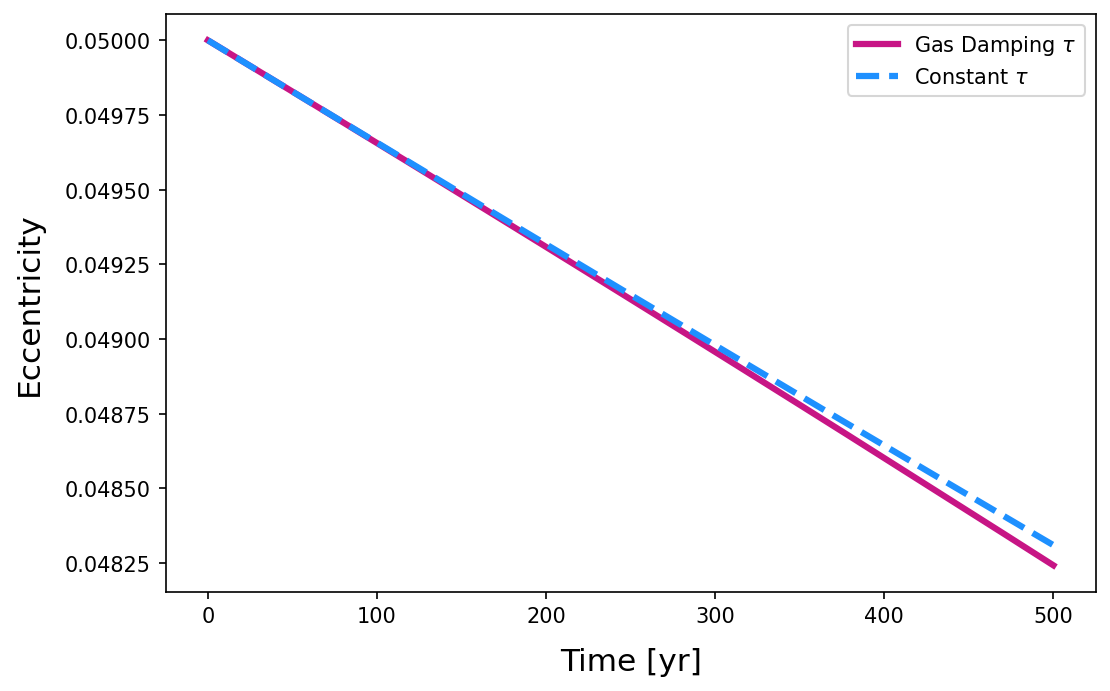

In [6]:
# for the constant timescale, let's use the initial damping timescale and keep it constant
ecc_const_tau = e0*np.exp(-times/calc_tau(d=5, m=3e-6, a=0.1, e=e0, i=inc0))

fig = plt.figure(figsize=(8,5), dpi=150)
plt.plot(times, ecc, color='mediumvioletred', linewidth=3, label=r'Gas Damping $\tau$')
plt.plot(times, ecc_const_tau, color='dodgerblue', linestyle='dashed', linewidth=3, label=r'Constant $\tau$')
plt.ylabel('Eccentricity', fontsize=15, labelpad=10)
plt.xlabel('Time [yr]', fontsize=15, labelpad=10)
plt.legend()

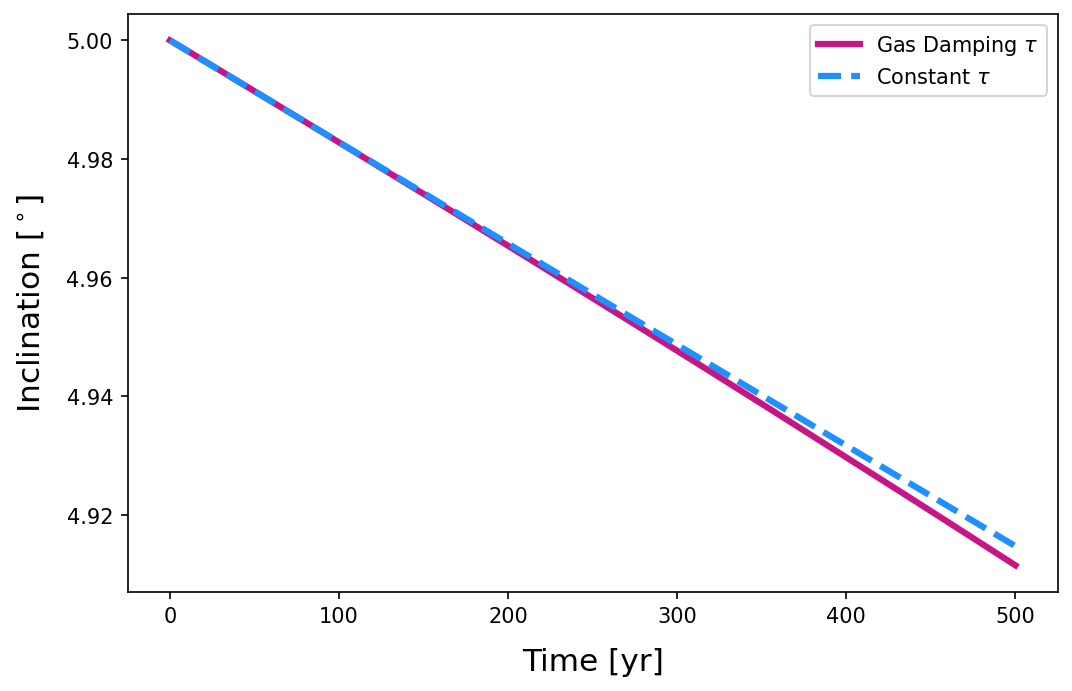

In [7]:
inc_const_tau = inc0*np.exp(-times/(2*calc_tau(d=5, m=3e-6, a=0.1, e=e0, i=inc0)))

fig = plt.figure(figsize=(8,5), dpi=150)
plt.plot(times, inc*180/np.pi, color='mediumvioletred', linewidth=3, label=r'Gas Damping $\tau$')
plt.plot(times, inc_const_tau*180/np.pi, color='dodgerblue', linestyle='dashed', linewidth=3, label=r'Constant $\tau$')
plt.ylabel(r'Inclination [$^\circ$]', fontsize=15, labelpad=10)
plt.xlabel('Time [yr]', fontsize=15, labelpad=10)
plt.legend()

We see in both cases, keeping the damping timescale constant would underestimate the amount of gas damping that occurs when the timescale is able to change over time, adapting to a planet's changing parameters.

Additionally, using a damping timescale that accounts for different planet parameters is especially important when dealing with **multiple planets**, which could undergo mergers (i.e., changing a particle's mass) or planet-planet scatterings (i.e., changing a particle's orbital characteristics).